### 数据清洗

In [1]:
# 导入必要的包
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# 读取数据
breast = pd.read_csv("BreastCancer.csv")

# 查看是否有缺失值
print(breast.count())

# 用中位数填充缺失值
breast['Bare.nuclei'].fillna(breast['Bare.nuclei'].median(), inplace=True)

# 将类别变量转化为数值变量
breast['label'] = breast['Class'].map({'benign': 0, 'malignant': 1})

# 查看数据前5行
breast.head()

Id                 699
Cl.thickness       699
Cell.size          699
Cell.shape         699
Marg.adhesion      699
Epith.c.size       699
Bare.nuclei        683
Bl.cromatin        699
Normal.nucleoli    699
Mitoses            699
Class              699
dtype: int64


,Id,Cl.thickness,Cell.size,Cell.shape,Marg.adhesion,Epith.c.size,Bare.nuclei,Bl.cromatin,Normal.nucleoli,Mitoses,Class,label
0,1000025,5,1,1,1,2,1.0,3,1,1,benign,0
1,1002945,5,4,4,5,7,10.0,3,2,1,benign,0
2,1015425,3,1,1,1,2,2.0,3,1,1,benign,0
3,1016277,6,8,8,1,3,4.0,3,7,1,benign,0
4,1017023,4,1,1,3,2,1.0,3,1,1,benign,0


## 数据分析与可视化

In [6]:
# 去除非数值变量列，便于数据分析
breast_eda = breast.drop(['Id', 'Class'], axis=1)

# 将数据分为良/恶性肿瘤
benign_eda = breast_eda[breast['label'] == 0].iloc[:, :-1]
malignant_eda = breast_eda[breast['label'] == 1].iloc[:, :-1]

### 数据分布分析

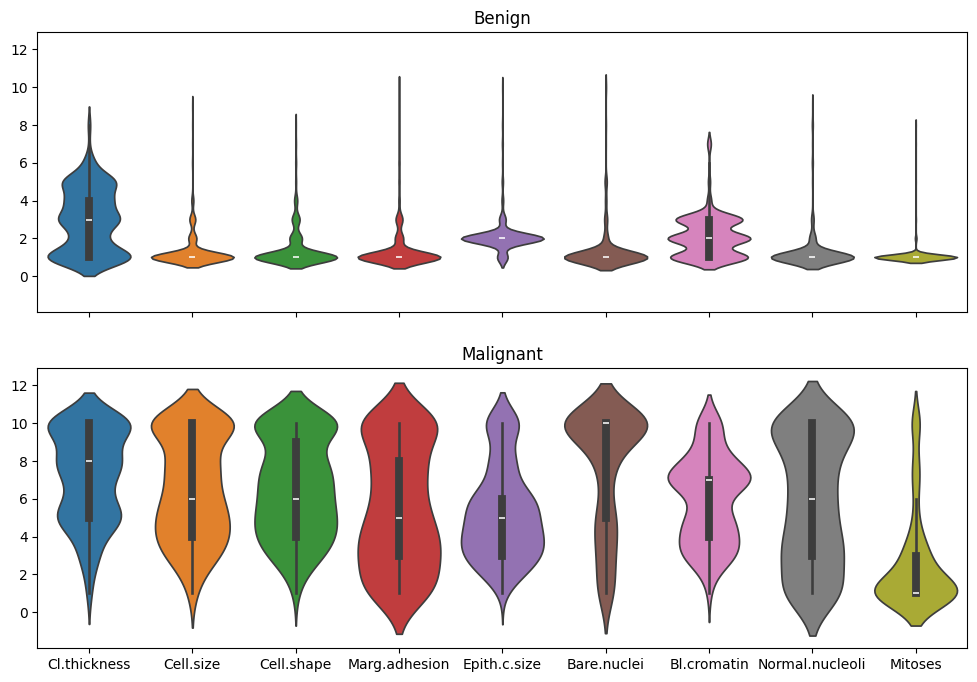

In [4]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True, sharey=True)

sns.violinplot(benign_eda, ax=ax1)
ax1.set_title('Benign')

sns.violinplot(malignant_eda, ax=ax2)
ax2.set_title('Malignant')

plt.show()

### 均值差置信区间

In [12]:
import scipy.stats as stats

# 计算每一列均值差的置信区间（大样本近似）
alpha = 0.95  # 置信水平

# 存储每一列的置信区间
conf_intervals = []

for col in benign_eda.columns:
    # 计算均值差的标准误
    se = np.sqrt(benign_eda[col].var() / len(benign_eda[col]) +
                 malignant_eda[col].var() / len(malignant_eda[col]))
    # 计算均值差的置信区间
    z = stats.norm.ppf(1 - (1 - alpha) / 2)  # 正态分布的分位数
    mean_diff = malignant_eda[col].mean() - benign_eda[col].mean()
    lower_bound = mean_diff - z * se
    upper_bound = mean_diff + z * se
    conf_intervals.append((lower_bound, upper_bound))

# 打印每一列的置信区间
for i, (lower_bound, upper_bound) in enumerate(conf_intervals):
    print(
        f"95% CI for {benign_eda.columns[i]}: ({lower_bound.round(2)}, {upper_bound.round(2)})")

95% CI for Cl.thickness: (3.9, 4.58)
95% CI for Cell.size: (4.89, 5.6)
95% CI for Cell.shape: (4.78, 5.45)
95% CI for Marg.adhesion: (3.77, 4.6)
95% CI for Epith.c.size: (2.86, 3.5)
95% CI for Bare.nuclei: (5.82, 6.65)
95% CI for Bl.cromatin: (3.58, 4.18)
95% CI for Normal.nucleoli: (4.14, 5.01)
95% CI for Mitoses: (1.2, 1.85)


### 相关矩阵分析

In [13]:
# 计算相关系数矩阵
breast_corr = breast_eda.corr()

# 计算特征与label的相关性并排序
label_corr = breast_corr.iloc[:-1, -1].sort_values(ascending=False)
print(label_corr)

Bare.nuclei        0.818968
Cell.shape         0.818934
Cell.size          0.817904
Bl.cromatin        0.756616
Cl.thickness       0.716001
Normal.nucleoli    0.712244
Marg.adhesion      0.696800
Epith.c.size       0.682785
Mitoses            0.423170
Name: label, dtype: float64


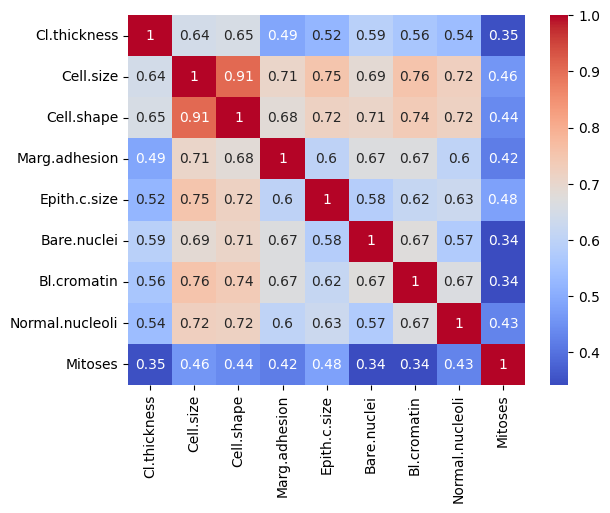

In [14]:
# 可视化特征间的相关性
feature_corr = breast_corr.iloc[:-1, :-1]
sns.heatmap(feature_corr, annot=True, cmap='coolwarm')

plt.show()

### 主成分分析（PCA）

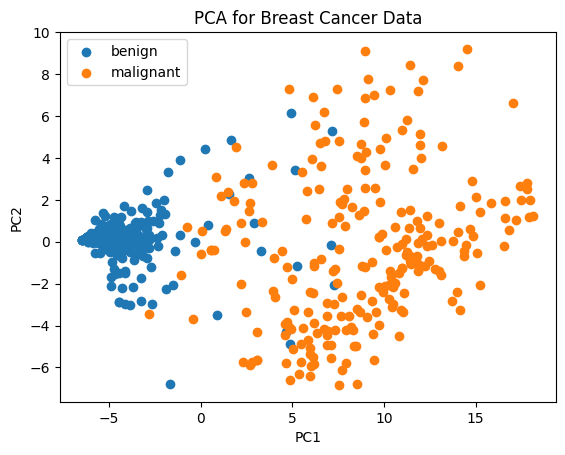

In [15]:
from sklearn.decomposition import PCA

breast_pca = PCA(2).fit_transform(breast_eda.iloc[:, :-1])  # 取主成分个数为2

# PCA可视化
y = breast['label']
names = ['benign', 'malignant']

for i in range(2):
    plt.scatter(breast_pca[y == i, 0], breast_pca[y == i, 1],
                label=names[i])

plt.title('PCA for Breast Cancer Data')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()

plt.show()

In [17]:
breast_pca[:5]

array([[-4.41834193,  0.03254866],
       [ 4.86191638, -4.86984201],
       [-4.5752774 , -0.62960962],
       [ 5.1654147 ,  3.40601259],
       [-4.05356076, -0.10501551]])

## 机器学习预测良/恶性肿瘤

In [18]:
# 导入必要的包
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc

### 数据预处理

In [19]:
# 读取数据输入
X = breast.iloc[:, 1:-3]
X.drop(['Cell.size'], axis=1, inplace=True)
y = breast['label']

# 对特征进行标准化
scale = StandardScaler()
X_scaled = scale.fit_transform(X)

# 查看标准化后的X
print(X_scaled.round(2))

[[ 0.21 -0.74 -0.63 ... -0.69 -0.18 -0.61]
 [ 0.21  0.27  0.77 ...  1.8  -0.18 -0.28]
 [-0.5  -0.74 -0.63 ... -0.41 -0.18 -0.61]
 ...
 [ 0.21  2.29  0.07 ... -0.13  1.87  2.34]
 [-0.15  0.94  0.42 ...  0.14  2.69  1.03]
 [-0.15  1.61  0.77 ...  0.42  2.69  0.37]]


### 数据集划分

In [20]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=666)
print(f"{X_train.shape[0]} samples in training set")
print(f"{X_test.shape[0]} samples in testing set")

559 samples in training set
140 samples in testing set


### 模型构建

In [21]:
# 创建logistic回归模型
logit = LogisticRegression()

# 拟合数据
logit.fit(X_train, y_train)

logit.predict_proba(X_train).round(2)

array([[0.  , 1.  ],
       [0.98, 0.02],
       [1.  , 0.  ],
       ...,
       [0.97, 0.03],
       [1.  , 0.  ],
       [0.  , 1.  ]])

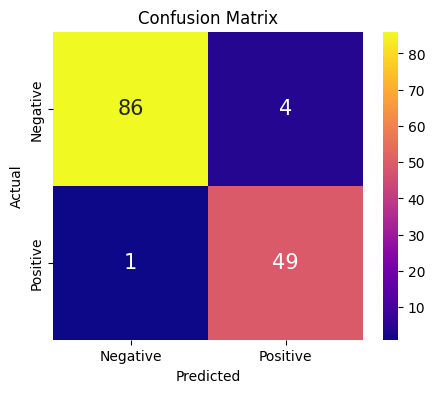

In [22]:
# 使用训练好的模型预测
y_pred = logit.predict(X_test)

# 计算混淆矩阵
confusion = confusion_matrix(y_test, y_pred)

# 绘制混淆矩阵热图
plt.figure(figsize=(5, 4))
sns.heatmap(confusion, annot=True, cmap='plasma',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'],
            annot_kws={"size": 15})
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

plt.show()

### 模型评估

#### 计算AUC

In [23]:
# 计算模型预测测试样本为正例（恶性）的概率
y_pred_proba = logit.predict_proba(X_test)[:, 1]

# 计算ROC曲线的假正例率（FPR）和真正例率（TPR）
fpr, tpr, threshold = roc_curve(y_test, y_pred_proba)

# 计算AUC值
AUC = auc(fpr, tpr)
print(AUC)

0.9915555555555556


#### 绘制ROC曲线

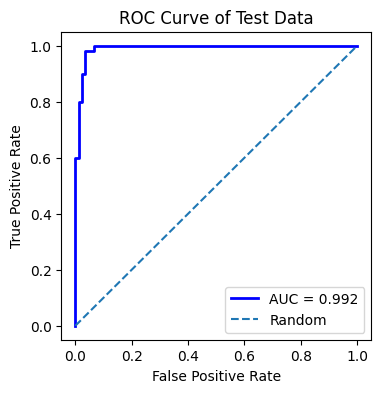

In [24]:
plt.figure(figsize=(4, 4))

plt.plot(fpr, tpr, '-', color='b', label=f"AUC = {AUC.round(3)}", lw=2)
plt.plot([0, 1], [0, 1], '--', label='Random')

plt.title('ROC Curve of Test Data')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

plt.show()